# Feature Evolution with Phase

This notebook explores the evolution of feature properties (e.g., pEW and velocities) as a function of phase.


In [1]:
from collections import OrderedDict
from pathlib import Path
from warnings import warn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.cosmology import WMAP9 as wmap9
from matplotlib.ticker import MultipleLocator
from scipy.stats.stats import pearsonr
from sndata.csp import DR3
from sndata.sdss import Sako18Spec
from sndata.utils import convert_to_jd


In [2]:
curr_dir = Path('.').resolve() 
results_dir = curr_dir.parent / 'results'

fig_dir = curr_dir / 'figures' / 'phase_evolution'
fig_dir.mkdir(parents=True, exist_ok=True)


In [3]:
dr3 = DR3()
dr3.download_module_data()

sako_18_spec = Sako18Spec()
sako_18_spec.download_module_data()


In [4]:
    feature_alias = {
        'pW1': 'Ca ii H&K',
        'pW2': 'Si ii λ4130',
        'pW3': 'Mg ii, Fe ii',
        'pW4': 'Fe ii, Si ii',
        'pW5': 'S ii λ5449, λ5622',
        'pW6': 'Si ii λ5972',
        'pW7': 'Si ii λ6355',
        'pW8': 'Ca ii IR triplet'}

## Reading in Data

In [5]:
csp_table_3 = dr3.load_table(3).to_pandas(index='SN')


@np.vectorize
def get_csp_t0(obj_id):
    """Get the t0 value for CSP targets

    Args:
        obj_id (str): The object identifier

    Returns:
        The time of B-band maximum in units of
    """
    
    # Unknown object ID
    if obj_id not in csp_table_3.index:
        return np.nan

    t0_mjd = csp_table_3.loc[obj_id]['T(Bmax)']

    # Known object Id with unknown peak time
    if np.isnan(t0_mjd):
        return np.nan

    return convert_to_jd(t0_mjd)


In [6]:
sdss_master_table = sako_18_spec.load_table('master').to_pandas(index='CID')


@np.vectorize
def get_sdss_t0(obj_id):
    """Get the t0 value for CSP targets

    Args:
        obj_id (str): The object identifier

    Returns:
        The time of B-band maximum in units of
    """
    
    obj_id = str(obj_id)
    
    # Unknown object ID
    if obj_id not in sdss_master_table.index:
        return np.nan

    t0_mjd = sdss_master_table.loc[obj_id]['PeakMJDSALT2zspec']

    # Known object Id with unknown peak time
    if np.isnan(t0_mjd):
        return np.nan

    return convert_to_jd(t0_mjd)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: TableReplaceWarning: converted column 'lcqualityIIPSNIDzs

In [7]:
def branch_classification(pipeline_data):
    """Return a series with the Branch classification for each objects
    
    Args:
        pipeline_data (DataFrame): Data that has been read from a pipeline output file
        
    Returns:
        A Pandas Series object
    """
    
    peak_vals = pipeline_data[pipeline_data.is_peak]
    df = peak_vals.loc['pW6'].join(
        peak_vals.loc['pW7'], 
        lsuffix='_pw6', 
        rsuffix='_pw7', 
        on='obj_id')

    classifications = np.full_like(df.index, 'unknown', dtype='U10')
    classifications[df.pew_pw6 > 30] = 'CL'
    classifications[(df.pew_pw7 > 105) & (df.pew_pw6 < 30)] = 'BL'
    classifications[df.pew_pw7 < 70] = 'SS'
    classifications[(70 <= df.pew_pw7) & (df.pew_pw7 <= 105) & (df.pew_pw6 <= 30)] = 'CN'
    return pd.Series(classifications, index=df.index, name='branch_type')


In [8]:
def read_in_pipeline_result(path, survey, drop_flagged=False):
    """Read pEW values from analysis pipeline file
    
    Adds columns for Branch classifications determined by the
    measured pEW values and spectral subtypes determined from 
    CSP DR1.
    
    Args:
        path          (str): Path of the file to read
        survey        (str): Read in data for either `csp` or `sdss`
        drop_flagged (bool): Optionally drop flagged measurements / spectra

    Returns:
        A pandas Dataframe indexed by feat_name and obj_id
    """
    
    df = pd.read_csv(path, index_col=['feat_name', 'obj_id'])

    # Add phases using CSP DR3 t0 values
    obj_id = df.index.get_level_values(1)
    
    if survey == 'csp':
        df['phase'] = df.time - get_csp_t0(obj_id)
        
        csp_table_2 = dr3.load_table(2)
        subtypes = pd.DataFrame({'spec_type': csp_table_2['Subtype1']}, index=csp_table_2['SN'])
        df = df.join(subtypes, on='obj_id')

    elif survey == 'sdss':
        df['phase'] = df.time - get_sdss_t0(obj_id)
        df['spec_type'] = 'unknown'
        
        sako_master = sako_18_spec.load_table('master').to_pandas()
        sako_master = sako_master.rename({'CID': 'obj_id'}, axis='columns')
        sako_master['obj_id'] = sako_master.obj_id.astype(int)
        sako_master = sako_master.set_index('obj_id')

        df = df.join(sako_master, how='inner')
        
    else:
        warn(f'Could not calculate phases for survey {survey}. Expected "csp" or "sdss".')
    
    if drop_flagged:
        df = df[(df.spec_flag != 1) & (df.feat_flag != 1)]
    
    # Label measurements that represent that were taken nearest peak brightness
    df['delta_t'] = df.phase.abs()
    df = df.sort_values('delta_t')
    df['is_peak'] = ~df.index.duplicated()
    
    df = df.join(branch_classification(df), on='obj_id')
    return df


In [11]:
# Load CSP measurements and drop any flagged values
csp_final = read_in_pipeline_result(results_dir / 'final_csp.csv', 'csp', drop_flagged=True)
csp_final.head()


,,time,feat_start,feat_end,vel,vel_err,vel_samperr,pew,pew_err,pew_samperr,area,area_err,area_samperr,spec_flag,feat_flag,notes,phase,spec_type,delta_t,is_peak,branch_type
feat_name,obj_id,,,,,,,,,,,,,,,,,,,,
pW8,2006ax,2453827.64,7850.5346,8559.4823,11063.857107,0.0,99.596716,118.560968,0.0,5.353396,1.065462e-13,0.0,5.790643e-15,0,0,NaN,0.03,normal,0.03,True,CN
pW7,2006ax,2453827.64,5906.1634,6330.9337,9625.073795,0.0,10.302926,91.479645,0.0,1.116834,2.475848e-13,0.0,3.889127e-15,0,0,NaN,0.03,normal,0.03,True,CN
pW6,2006ax,2453827.64,5678.8216,5906.1634,8723.595527,0.0,76.983772,9.265504,0.0,0.740855,2.944359e-14,0.0,2.452335e-15,0,0,NaN,0.03,normal,0.03,True,CN
pW5,2006ax,2453827.64,5197.2158,5621.9861,7704.467778,0.0,204.004878,79.384340,0.0,2.574018,3.093872e-13,0.0,1.194942e-14,0,0,NaN,0.03,normal,0.03,True,CN
pW4,2006ax,2453827.64,4524.1642,5197.2158,16623.134910,0.0,128.344411,120.703680,0.0,2.927860,6.353153e-13,0.0,1.818109e-14,0,0,NaN,0.03,normal,0.03,True,CN


In [76]:
# Load SDSS measurements and drop any flagged values
sdss_final = read_in_pipeline_result(results_dir / 'final_sdss.csv', 'sdss', drop_flagged=True)

#adds column 'kpc' 
sdss_final['arcmin'] = sdss_final.separationhost / 60
sdss_final['kpc'] = wmap9.kpc_comoving_per_arcmin(sdss_final.arcmin)
sdss_final['kpc'] = sdss_final['kpc'].replace(0,np.nan)

sdss_final['logSFRPEGASE']=sdss_final['logSFRPEGASE'].replace(-99,np.nan)
sdss_final['logSFRPEGASE']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'ndofSALT2zspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'ndofMLCS2k2zspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'lcqualityIaPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'lcqualityIbcPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'lcqualityIIPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: converted column 'NnnPSNIDzspec' from integer to float
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TableReplaceWarning: 

feat_name  obj_id
pW6        19128      NaN
pW2        2017      0.18
pW1        2017      0.18
pW2        19128      NaN
pW1        2689       NaN
                     ... 
           13796     0.07
pW7        13796     0.07
pW3        21034     1.10
pW4        21034     1.10
pW7        21034     1.10
Name: logSFRPEGASE, Length: 1195, dtype: float64

## Number of Measurements

In [11]:
def plot_number_feature_measurements(measured_data, hist_col=None, xlocator=1):
    """Plot a histogram of the number of measurements performed for each feature
    
    Args:
        measured_data (DataFrame): The measured data
        hist_col            (str): Name of the column to plot as the histogram
        xlocator          (float): Show xaxis tick marks as a multiple of this number
    """
    
    fig, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
    for (feature, data), axis in zip(measured_data.groupby(level=0), axes.flatten()):
        counts = data.index.value_counts() if hist_col is None else data[hist_col]
        axis.hist(counts, align='mid')
        axis.xaxis.set_major_locator(MultipleLocator(xlocator))
        axis.set_title(f'{feature_alias[feature]}')
        
    for axis in axes[:, 0]:
        axis.set_ylabel('Number of Objects')

    for axis in axes[-1]:
        xlabel = hist_col or 'Number of Measurements'
        axis.set_xlabel(xlabel)


Text(0.5, 0.98, 'Number of CSP Feature Measurements per Phase')

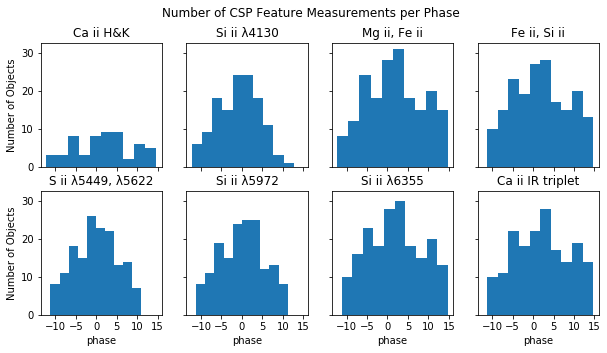

In [12]:
plot_number_feature_measurements(csp_final, 'phase', 5)
plt.gcf().suptitle('Number of CSP Feature Measurements per Phase')


Text(0.5, 0.98, 'Number of SDSS Feature Measurements per Phase')

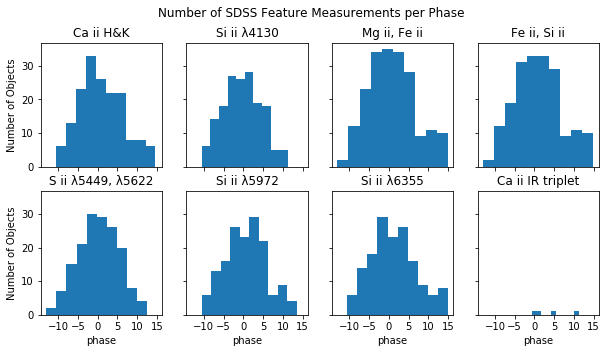

In [13]:
plot_number_feature_measurements(sdss_final, 'phase', 5)
plt.gcf().suptitle('Number of SDSS Feature Measurements per Phase')


Text(0.5, 0.98, 'Number of CSP Feature Measurements')

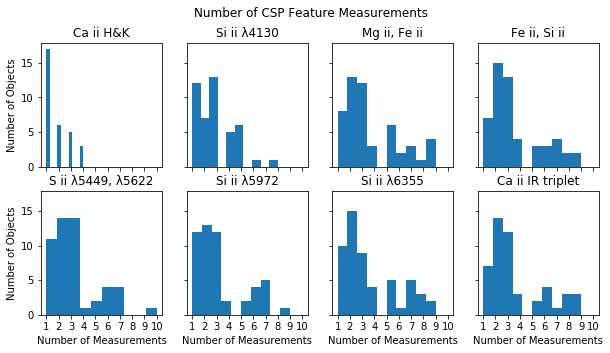

In [14]:
plot_number_feature_measurements(csp_final)
plt.gcf().suptitle('Number of CSP Feature Measurements')


Text(0.5, 0.98, 'Number of SDSS Measurements per Feature')

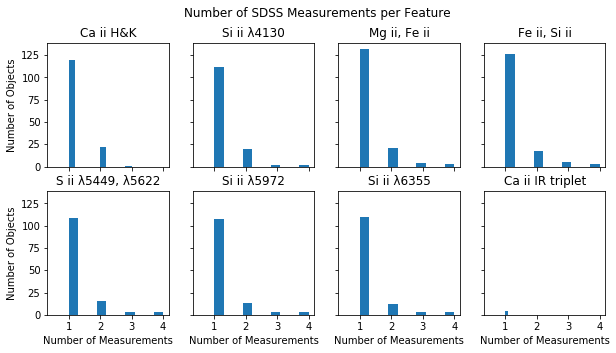

In [15]:
plot_number_feature_measurements(sdss_final)
plt.gcf().suptitle('Number of SDSS Measurements per Feature')


## Effect of Data Cuts

In [16]:
def plot_impact_of_phase_cut(measured_data, cutoff_vals, chosen_cutoff):
    """Plot the cumulative total number of measurements within a given number
    of days from maximum
    
    Args:
        measured_data (DataFrame): The measured data
        cutoff_vals        (List): Values to plot on x-axis in units of days
    """
    
    phase_abs = measured_data.phase.abs()
    
    fig, axis = plt.subplots(figsize=(10, 5))
    for feature, data in phase_abs.groupby(level=0):
        y_vals = [len(data[data <= c].index.unique(level=1)) for c in cutoff_vals]
        y_cutoff = len(data[data <= chosen_cutoff].index.unique(level=1))
        axis.plot(cutoff_vals, y_vals, label=f'{feature} ({y_cutoff})')
    
    axis.axvline(proposed_cutoff, color='k', linestyle='--')
    axis.set_ylabel('Number of Objects')
    axis.set_xlabel('Phase Cutoff')
    axis.set_xlim(min(cutoff_vals), max(cutoff_vals))
    axis.set_ylim(0)
    axis.legend()
        

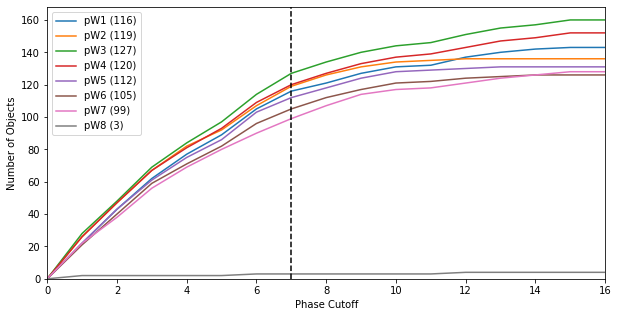

In [17]:
proposed_cutoff = 7
plot_impact_of_phase_cut(sdss_final, np.arange(16, -1, -1), proposed_cutoff)



In [18]:
def cutoff_histogram(pipeline_data, hist_col, cutoff, xlabel=None, figsize=(4, 4)):
    """Plot overlapping histograms for kept and dropped data
    
    Args:
        pipeline_data (DataFrame): Data from a pipeline output file
        hist_col            (str): Column name to use for histogram data
        cutoff            (float): Phase cutoff used to drop data
        xlabgel             (str): Optional xaxis label (defaults to xcol)
        figsize           (Tuple): Size of the figure in inches
    """
    
    pipeline_data = pipeline_data[pipeline_data.is_peak]
    
    kept_data = pipeline_data[pipeline_data.delta_t <= cutoff][hist_col]
    dropped_data = pipeline_data[pipeline_data.delta_t > cutoff][hist_col]
    
    fig, axis = plt.subplots(figsize=figsize)
    axis.hist(kept_data)
    axis.hist(dropped_data, histtype='step', hatch='//', linewidth=2)
    
    axis.set_xlabel(xlabel or hist_col)
    axis.set_ylabel('Number of Objects')


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


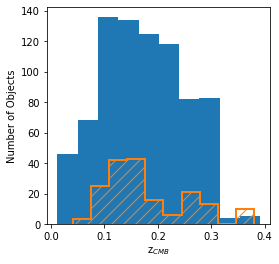

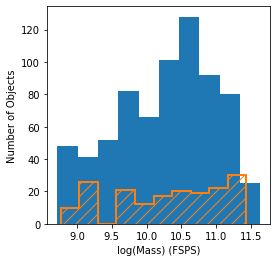

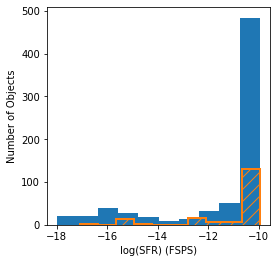

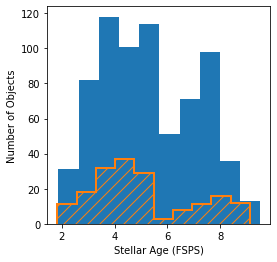

In [19]:
colnames = ['zCMB', 'logMassFSPS', 'logSSFRFSPS', 'ageFSPS']
xlabels = [r'z$_{CMB}$', r'log(Mass) (FSPS)', r'log(SFR) (FSPS)', r'Stellar Age (FSPS)']

for col, xl in zip(colnames, xlabels):
    cutoff_histogram(sdss_final, col, 7, xl)


## Branch Classifications

In [20]:
def plot_branch_classifications(pipeline_data, phase_cutoff=7, figsize=(10, 10)):
    """Create a Branch classification figure
    
    Args:
        pipeline_data (DataFrame): Data that has been read from a pipeline output file
        phase_cutoff      (float): Only use measurements taken within so many days of peak brightness
        fig_size          (Tuple): Size of the figure in inches
    """
    
    fig, axis = plt.subplots(figsize=figsize)
    
    plot_args = {
        'CL': dict(label='Cool', color='blue', marker='s'),
        'BL': dict(label='Broad Line', color='red' , marker='^'),
        'SS': dict(label='Shallow Silicon', color='green' , marker= '*'),
        'CN': dict(label='Core Normal', color='black' , marker= '.')
    }
    peak_vals = pipeline_data[pipeline_data.is_peak]
    peak_vals = peak_vals[peak_vals.delta_t <= phase_cutoff]
    
    pw6_data = peak_vals[['pew', 'pew_samperr', 'branch_type']].loc['pW6']
    all_data = pw6_data.join(peak_vals[['pew', 'pew_samperr']].loc['pW7'], lsuffix='_6', rsuffix='_7').dropna()

    for branch_class, data in all_data.groupby('branch_type'):
        label = plot_args[branch_class].pop('label') + f' ({len(data)})'
        axis.errorbar(
            data.pew_7, 
            data.pew_6, 
            xerr=data.pew_samperr_7,
            yerr=data.pew_samperr_6,
            linestyle='',
            label=label,
            **plot_args.get(branch_class, dict()))
    
    plt.title('Strength of pW6 vs pW7')
    axis.legend(loc = ('upper left'))
    plt.xlabel('pew of pW7')
    plt.ylabel('pew of pW6')
    

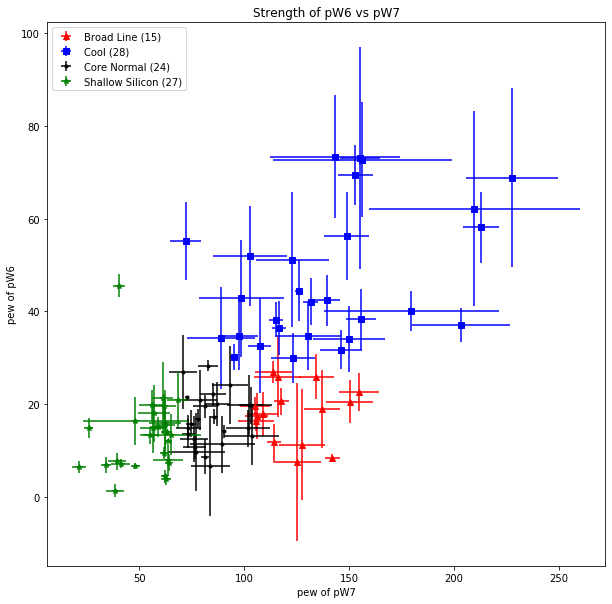

In [21]:
plot_branch_classifications(sdss_final, proposed_cutoff)


In [61]:
branch_outliers = ['10449', '16021', '1371', '6773', '7147', '16099', 
                   '16281', '18375', '18697', '21502']

## pEW and Velocity Vs. Phase

In [22]:
def plot_feat_evolution(feature_data, plot_col='pew', color_by='spec_type', kwargs=None, axis=None):
    """Plot the strength of a feature vs phase
    
    Args:
        feature_data (DataFrame): Dataframe to plot data from
        plot_col           (str): Column to plot on the y axis 
        color_by           (str): Name of the column to color code points by
        kwargs      (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
        axis              (Axis): Optionally plot on a given axis
    """

    # Set default values
    kwargs = dict() if kwargs is None else kwargs
    if axis is None:
        fig, axis = plt.subplots(figsize=(6, 4))
    
    feature_data = feature_data.sort_values('phase')
    for i, (class_name, class_data) in enumerate(feature_data.groupby(color_by)):
        x = class_data.phase
        y = class_data[plot_col]
        y_err = class_data[plot_col + '_samperr']
        
        plot_kw = kwargs.get(class_name, dict())
        axis.errorbar(x, y, yerr=y_err, linestyle='', **plot_kw)
        axis.scatter(x, y, s=10, label=class_name,  **plot_kw)
    
    if axis is None:
        axis.set_xlabel('Phase', fontsize=12)
        axis.set_ylabel(r'pEW ($\AA$)', fontsize=12)
        
    axis.set_xlim(-15, 15)
    

In [23]:
def plot_all_features(df, plot_col='pew', color_by='spec_type', kwargs=None):
    """Plot pEW measurements vs. phase for all 8 features
    
    Args:
        df      (DataFrame): Dataframe to plot data from
        plot_col      (str): Column to plot on the y axis
        color_by      (str): Name of the column to color code points by
        kwargs (dict[dict]): Plotting kwargs for each unique value in the `color_by` column
    """

    # Set default values
    kwargs = dict() if kwargs is None else kwargs
    plot_features = feature_alias.copy()
    
    fig, axes = plt.subplots(4, 2, sharex=True, figsize=(7.5, 10))
    for axis, feature in zip(axes.flatten(), plot_features):
        axis.set_title(f'{plot_features[feature]} ({feature})')

        feature_data = df.loc[feature]
        plot_feat_evolution(
            feature_data, plot_col=plot_col,
            color_by=color_by, axis=axis, kwargs=kwargs)
        
    for axis in axes[:, 0]:
        axis.set_ylabel(plot_col, fontsize=12)
    
    for axis in axes[-1, :]:
        axis.set_xlabel('Phase', fontsize=12)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), framealpha=1, bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    

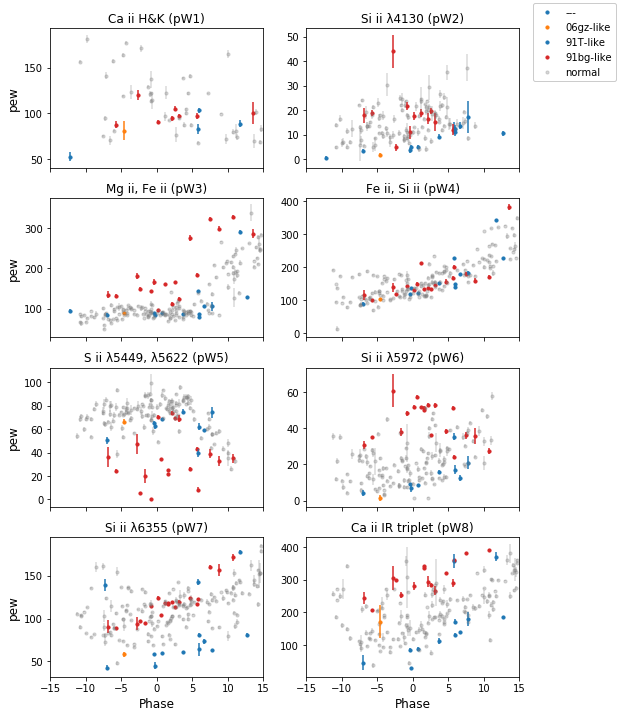

In [24]:
csp_kwargs = {
    'normal': {'color': 'grey', 'alpha': .3},
    '91bg-like': {'color': 'C3'},
    '91T-like': {'color': 'C0'},
    '06gz-like': {'color': 'C1'}
}

plot_all_features(csp_final, kwargs=csp_kwargs, color_by='spec_type')
plt.savefig(fig_dir / 'csp_pew.pdf')


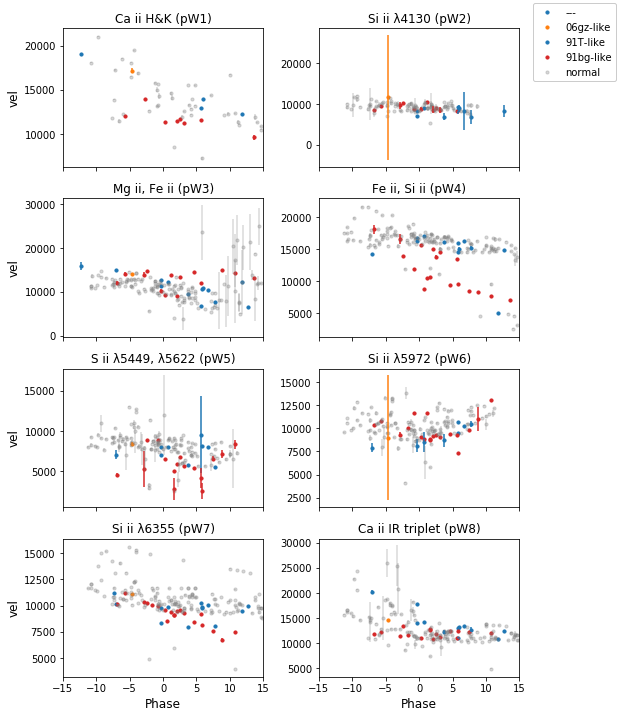

In [25]:
plot_all_features(csp_final, 'vel',  kwargs=csp_kwargs, color_by='spec_type')
plt.savefig(fig_dir / 'csp_vel.pdf')


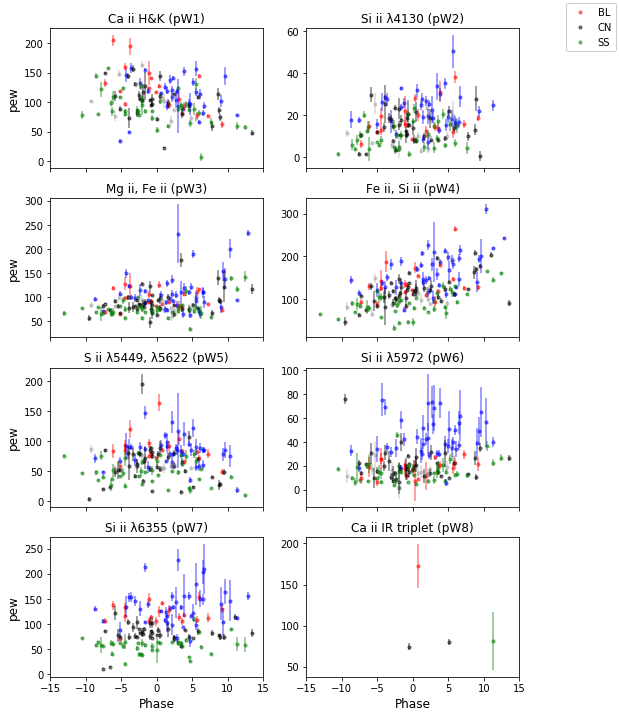

In [26]:
sdss_kwargs = {
    'BL': {'color': 'red', 'alpha': .5},
    'SS': {'color':'green', 'alpha': .5},
    'CL':{'color':'blue', 'alpha': .5},
    'CN':{'color':'black', 'alpha': .5},
    'unknown': {'color': 'grey', 'alpha': .3}
}

plot_all_features(sdss_final, kwargs=sdss_kwargs, color_by='branch_type')
plt.savefig(fig_dir / 'sdss_pew.pdf')


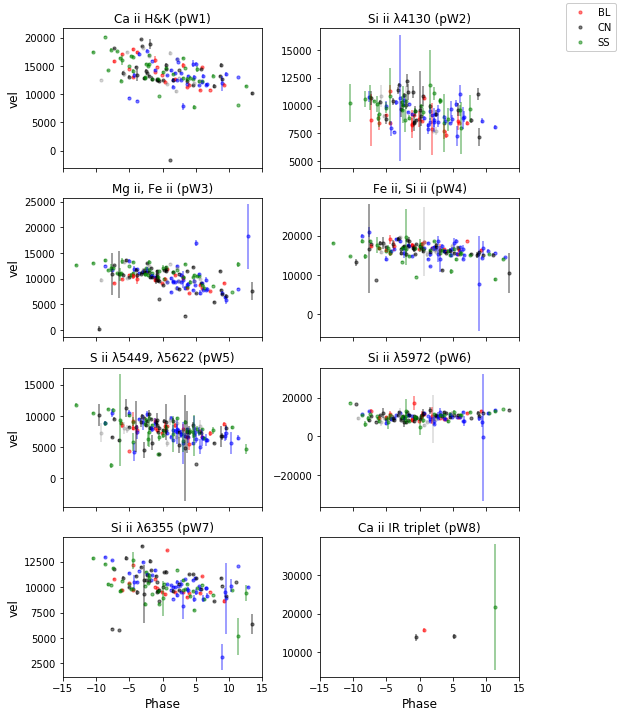

In [27]:
plot_all_features(sdss_final, 'vel', kwargs=sdss_kwargs, color_by='branch_type')
plt.savefig(fig_dir / 'sdss_vel.pdf')


## Host Galaxy Trends

In [28]:
def create_corner_hist_figure(
    num_subfigs=8, subfigs_per_row=2, fig_size=(6.5, 9), xlabel=None, ylabel=None, vspace=.15, hspace=.15
):
    """Create a figure containing axes for multiple scatter plots with bordering histograms
    
    Args:
        num_subfigs     (int): Number of axes to make for scatter plots
        subfigs_per_row (int): Number of Scatter plot axes per row
        fig_size      (Tuple): The size of the figure
        x_label         (str): x-label to use for the figure
        ylabel          (str): y-label to use for the figure
        
    Returns:
        The matplolib figure
        An array of axes for scatter plots
        An array of axes for x-axis histograms
        An array of axes for y-axis histograms
    """
    
    # Calculate the number and relative width of each column
    columns_per_feature = 3
    num_columns = (subfigs_per_row * columns_per_feature) - 1

    histogram_width = .5
    width_ratios = np.ones(num_columns)
    width_ratios[2::3] = hspace
    width_ratios[1::3] = histogram_width
    width_ratios /= sum(width_ratios)

    # Calculate the number and relative height of each row
    rows_per_feature = 3
    num_rows = int(np.ceil(num_subfigs / subfigs_per_row * rows_per_feature)) - 1

    spacer_height = .15
    histogram_height = .5
    height_ratios = np.ones(num_rows)
    height_ratios[0::3] = histogram_height
    height_ratios[2::3] = vspace
    height_ratios /= sum(height_ratios)

    # Create all subplots. We'll go in and hide the spacer subplots after
    fig, axes = plt.subplots(
        num_rows, num_columns,
        figsize=fig_size,
        gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios, 'hspace': 0, 'wspace': 0})

    # Hide spacer columns
    for axis in axes[:, 2::columns_per_feature].flatten():
        axis.set_visible(False)

    # Hide spacer rows
    for axis in axes[2::rows_per_feature].flatten():
        axis.set_visible(False)

    # Hide axes in the corner formed by histogram subplots
    for axis in axes[0::rows_per_feature, 1::columns_per_feature].flatten():
        axis.set_visible(False)

    scatter_axes = axes[1::rows_per_feature, 0::columns_per_feature].flatten()
    vertical_hist = axes[1::rows_per_feature, 1::columns_per_feature].flatten()
    horizontal_hist = axes[0::rows_per_feature, 0::columns_per_feature].flatten()
    for sax, vax, hax in zip(scatter_axes, vertical_hist, horizontal_hist):
        sax.sharex = hax 
        sax.sharey = vax 
        
    # Assign labels
    for axis in axes[1::rows_per_feature, 0].flatten():
        axis.set_ylabel(ylabel)
        
    for axis in axes[-1, 0::columns_per_feature].flatten():
        axis.set_xlabel(xlabel)
        
    
    return fig, scatter_axes, horizontal_hist, vertical_hist


In [29]:
def plot_scatter_hist(data, features, xcol, ycol, yerrcol=None, xlabel=None, ylabel=None, figsize=None):
    """Create scatter plots with bordering histograms
    
    One scatter plot is created for each of the specified features
    
    Args:
        data     (DataFrame): The data to plot
        features (List[str]): The feature ids to plot
        xcol           (str): Name of the column to plot along the x-axis
        ycol           (str): Name of the column to plot along the y-axis
        xlabel         (str): Optional x label (defaults to same value as xcol)
        ylabel         (str): Optional x label (defaults to same value as ycol)
    """
    
    fig, *axes = create_corner_hist_figure(
        num_subfigs=len(features), 
        fig_size=figsize or (10, 20),
        vspace=.2,
        xlabel=xcol if xlabel is None else xlabel,
        ylabel=ycol if ylabel is None else ylabel)

    for feat, scatter_ax, horizontal_ax, vertical_ax in zip(features, *axes):
        feat_data = data.loc[feat]
        x = feat_data[xcol]
        y = feat_data[ycol]
        
        if yerrcol:
            scatter_ax.errorbar(x, y, feat_data[yerrcol], linestyle='', alpha = 0.3)
        
    
            color_data = feat_data.copy()
            color_data = color_data.reset_index()
            color_data['branch_type'] = color_data['branch_type'].fillna('unknown')
            color_data = color_data.branch_type.map(dict(BL='red', SS='green', CL='blue', CN='black', unknown='grey', nan = 'grey'))
            color_data = color_data.values
            scatter_ax.scatter(x, y, s=8, c=color_data, alpha=0.7)
            horizontal_ax.hist(x)
            vertical_ax.hist(y, orientation='horizontal')
            
            #scatter_ax.errorbar(x, y, feat_data[yerrcol], linestyle='', c=color_data)
        



In [30]:
sdss_combined = sdss_final[
    (sdss_final.delta_t <= proposed_cutoff) &
    (sdss_final.is_peak)]
sdss_combined.to_csv(results_dir / 'sdss_combined.csv')

In [41]:
def outlier_finder(df, feature, prop, p_or_v, xmin, xmax, ymin, ymax):
    df = df.reset_index()
    df = df[df['feat_name'] == feature]
    df = df[(df[p_or_v] >= ymin) & (df[p_or_v] <= ymax)]
    df = df[(df[prop] >= xmin) & (df[prop] <= xmax)]
    return df['obj_id'].to_string(index = False)

# redshift

In [48]:
#redshift pew
print(outlier_finder(sdss_combined, 'pW1', 'zCMB', 'pew', 0, 0.1, 0, 50))
print(outlier_finder(sdss_combined, 'pW1', 'zCMB', 'pew', 0, 0.5, 200, 400))
print(outlier_finder(sdss_combined, 'pW2', 'zCMB', 'pew', 0, 0.5, 40, 400))
print(outlier_finder(sdss_combined, 'pW3', 'zCMB', 'pew', 0, 0.5, 150, 400))
print(outlier_finder(sdss_combined, 'pW4', 'zCMB', 'pew', 0.35, 0.5, 0, 400))
print(outlier_finder(sdss_combined, 'pW5', 'zCMB', 'pew', 0, 0.5, 145, 400))

 16280
  3901
 17825
 2330
  1580
 15369
 13072
 5737
  5994
 16287
  6422


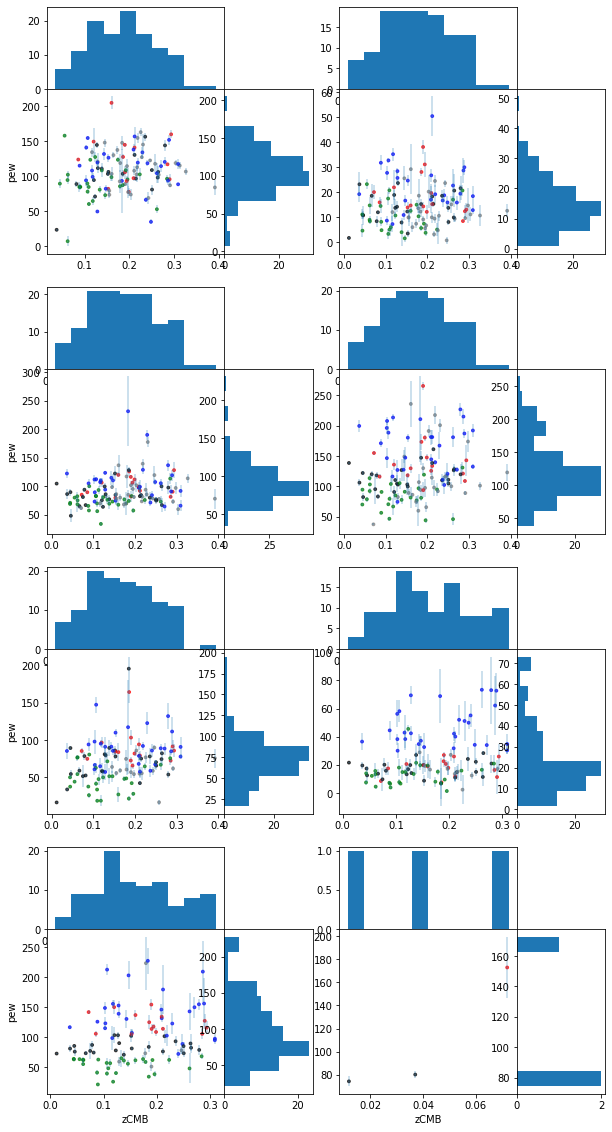

In [34]:
#KF, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zCMB', 
    'pew', 
    'pew_samperr')


In [60]:
# redshift vel
print(outlier_finder(sdss_combined, 'pW1', 'zCMB', 'vel', 0, 0.1, -20000, 0))
print(outlier_finder(sdss_combined, 'pW3', 'zCMB', 'vel', 0.2, 0.3, 16000, 40000))
print(outlier_finder(sdss_combined, 'pW4', 'zCMB', 'vel', 0, 0.5, 25000, 40000))
print(outlier_finder(sdss_combined, 'pW6', 'zCMB', 'vel', 0, 0.5, 15000, 40000))

 16280
 13072
 16333
 6933


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


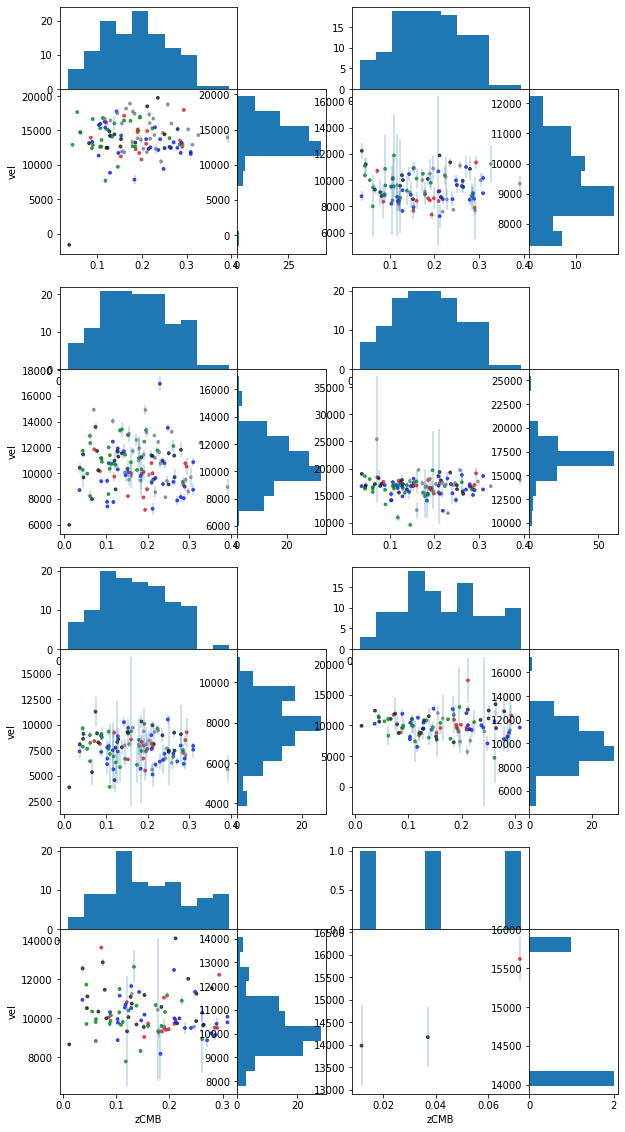

In [49]:
#KF, velocity
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zCMB', 
    'vel', 
    'vel_samperr')

In [ ]:
#RF, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zspecHelio', 
    'pew', 
    'pew_samperr')

In [ ]:
#RF, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'zspecHelio', 
    'vel', 
    'vel_samperr')

# host mass

In [67]:
# host mass pew
print(outlier_finder(sdss_combined, 'pW1', 'logMassFSPS', 'pew', 0, 11, 0, 25))
print(outlier_finder(sdss_combined, 'pW2', 'logMassFSPS', 'pew', 0, 11, 45, 500))
print(outlier_finder(sdss_combined, 'pW3', 'logMassFSPS', 'pew', 0, 50, 150, 500))
print(outlier_finder(sdss_combined, 'pW5', 'logMassFSPS', 'pew', 0, 50, 175, 500))

 16280
  3901
 2330
  1580
 15369
 13072
 6422


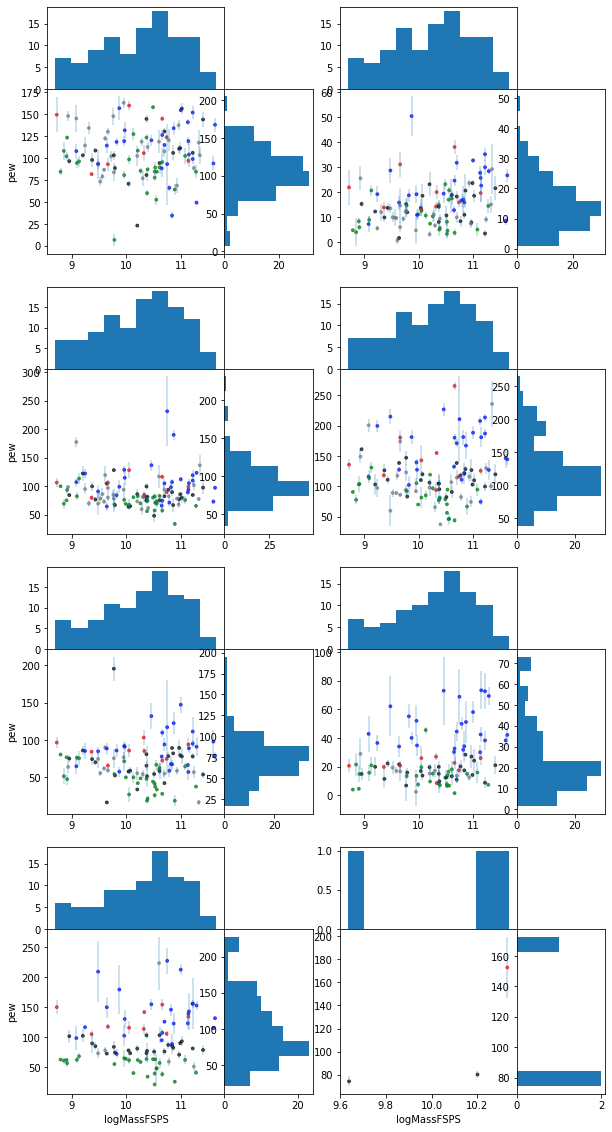

In [62]:
# FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassFSPS', 
    'pew', 
    'pew_samperr')

In [73]:
# host mass vel
print(outlier_finder(sdss_combined, 'pW1', 'logMassFSPS', 'vel', 0, 11, -20000, 0))
print(outlier_finder(sdss_combined, 'pW3', 'logMassFSPS', 'vel', 0, 50, 16000, 50000))
print(outlier_finder(sdss_combined, 'pW4', 'logMassFSPS', 'vel', 0, 50, 22500, 50000))

 16280
 13072
 16333


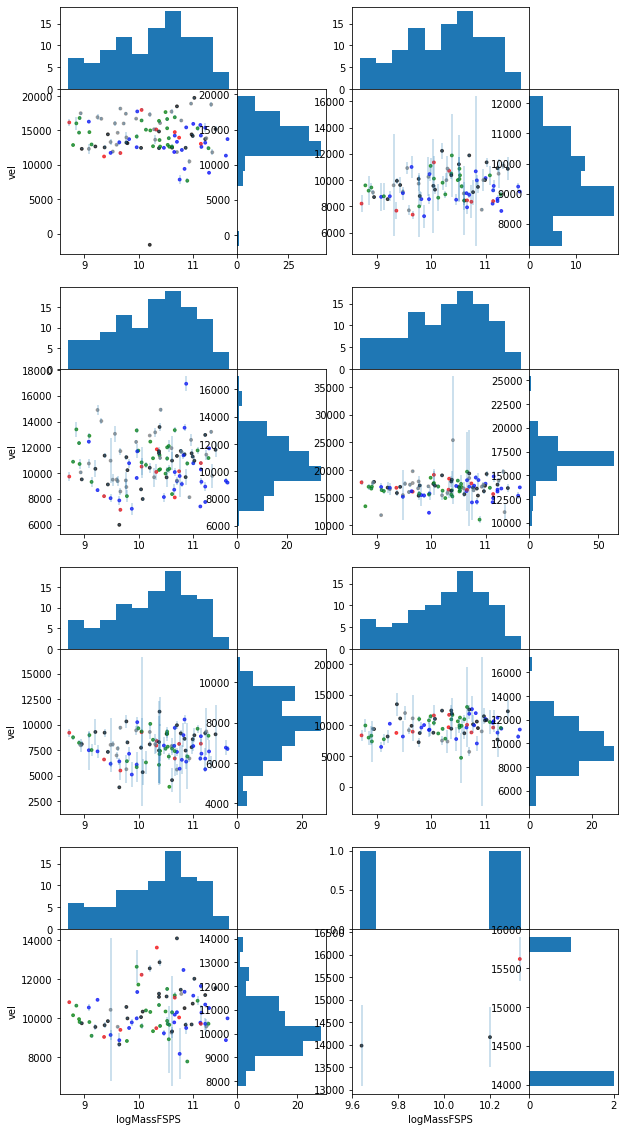

In [63]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassFSPS', 
    'vel', 
    'vel_samperr')

In [ ]:
# PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassPEGASE', 
    'pew', 
    'pew_samperr')

In [ ]:
# PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logMassPEGASE', 
    'vel', 
    'vel_samperr')

# SFR

In [81]:
#SSFR pew
print(outlier_finder(sdss_combined, 'pW3', 'logSSFRFSPS', 'pew', -18, -16, 200, 250))
print(outlier_finder(sdss_combined, 'pW6', 'logSSFRFSPS', 'pew', -18, -16, 60, 80))

 1580
  1253
  1580
 20350


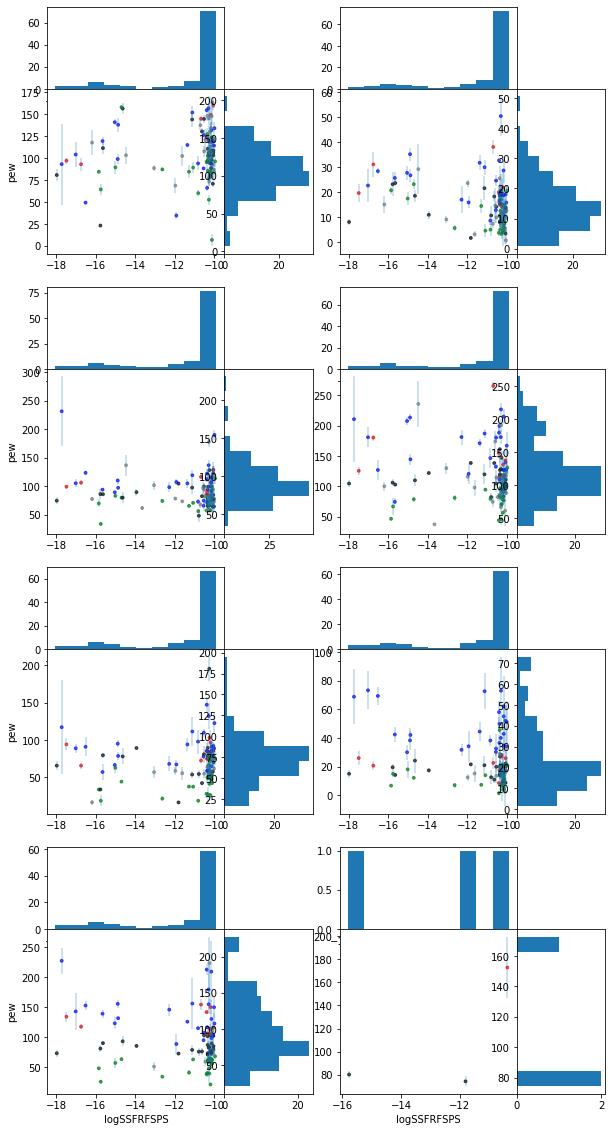

In [77]:
#FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'pew', 
    'pew_samperr')

In [85]:
#SSFR vel
print(outlier_finder(sdss_combined, 'pW1', 'logSSFRFSPS', 'vel', -18, -12, -20000, 0))
print(outlier_finder(sdss_combined, 'pW4', 'logSSFRFSPS', 'vel', -18, -10, 22500, 500000))

 16280
 16333


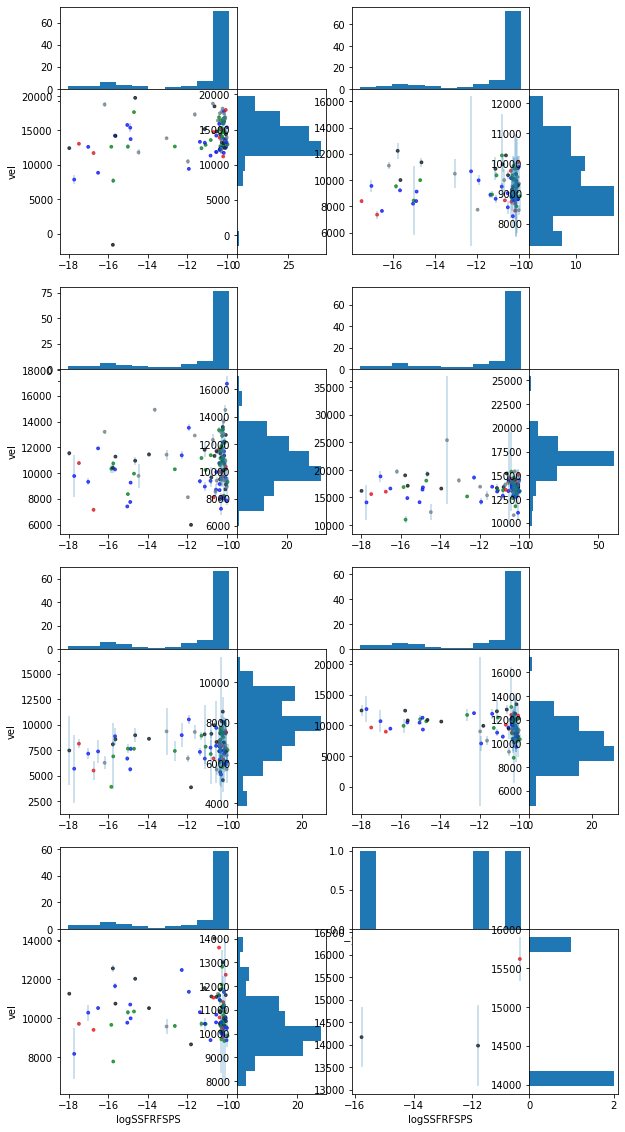

In [78]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'vel', 
    'vel_samperr')

In [ ]:
# FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSSFRFSPS', 
    'pew', 
    'pew_samperr')

In [ ]:

#PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSFRPEGASE', 
    'pew', 
    'pew_samperr')

In [ ]:
#PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'logSFRPEGASE', 
    'vel', 
    'vel_samperr')

# Age

In [ ]:
#FSPS, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'ageFSPS', 
    'pew', 
    'pew_samperr')

In [ ]:
#FSPS, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'ageFSPS', 
    'vel', 
    'vel_samperr')

In [ ]:
#PEGASE, pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'agePEGASE', 
    'pew', 
    'pew_samperr')

In [ ]:
#PEGASE, vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'agePEGASE', 
    'vel', 
    'vel_samperr')

# vel

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'vel', 
    'pew', 
    'pew_samperr')

# distance from SN to host reg, norm

In [ ]:
# pew
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'kpc', 
    'pew', 
    'pew_samperr')

In [ ]:
#vel
features = [f'pW{i}' for i in range(1, 9)]
plot_scatter_hist(
    sdss_combined, 
    features, 
    'kpc', 
    'vel', 
    'vel_samperr')

In [ ]:
def pearson_list(df, features, xcol, ycol):
    """Creates lists of pearson statistic p and c values for each feature for any two given columns
        used in pearson_table_make function
    
    Args:
        df     (DataFrame): The dataframe in which the columns we want to compare are
        features (List[str]): The feature ids to add to table
        xcol           (str): Name of one column to compare
        ycol           (str): Name of second column to compare
    
    Returns:
        p_list   (List[float]): List of P values
        c_list   (List[float]): List of c values
    """
    
    p_list = []
    c_list = []
    
    for feat in zip(features):
        feat_data = df.loc[feat]
        x = feat_data[xcol]
        y = feat_data[ycol]
        
        no_nan = (np.isfinite(x) & np.isfinite(y))
        
        if len(x[no_nan]) >= 3:
            corr, p = pearsonr(x[no_nan], y[no_nan])
            p_list.append(p)
            c_list.append(corr)
            
        else:
            p_list.append(np.nan)
            c_list.append(np.nan)
        
    return p_list, c_list
        

In [ ]:
def pearson_table_make(df, features):
    """Creates data frame of p and c pearson stat values for specific columns vs. pew and vel
    
    Args:
        df     (DataFrame): The dataframe in which the columns we want to compare are
        features (List[str]): The feature ids to add to table 
        
    Returns:
        data    (DataFrame): Table of p and c values for different qualities vs pew and vel.
    """
        
    data = pd.DataFrame()
    data['features'] = features
    
    df = df_col = df[['zCMB','zspecHelio','logMassFSPS','logSSFRFSPS',
                      'ageFSPS','kpc', 'pew','vel']]
    df_col = df[['zCMB','zspecHelio','logMassFSPS','logSSFRFSPS'
                 ,'ageFSPS','kpc',]]
    
    for column in df_col:
        p_pew, c_pew = pearson_list(df, features, column , 'pew')
        data[f'{column}_c_pew'] = c_pew
        data[f'{column}_p_pew'] = p_pew
        p_vel, c_vel = pearson_list(df, features, column, 'vel')
        data[f'{column}_c_vel'] = c_vel
        data[f'{column}_p_vel'] = p_vel
    
    data = data.set_index('features')
    return data

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
pearson_table = pearson_table_make(sdss_combined, features)
pearson_table.to_csv(results_dir / 'pearson_table.csv')

pearson_table

In [ ]:
sdss_cl = sdss_combined[sdss_combined['branch_type'] == 'CL']
sdss_bl = sdss_combined[sdss_combined['branch_type'] == 'BL']
sdss_cn = sdss_combined[sdss_combined['branch_type'] == 'CN']
sdss_ss = sdss_combined[sdss_combined['branch_type'] == 'SS']

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
bl_pearson_table = pearson_table_make(sdss_bl, features)
bl_pearson_table.to_csv(results_dir / 'bl_pearson_table.csv')
bl_pearson_table

In [ ]:
features = [f'pW{i}' for i in range(1, 9)]
cn_pearson_table = pearson_table_make(sdss_cn, features)
cn_pearson_table.to_csv(results_dir / 'cn_pearson_table.csv')
cn_pearson_table

In [ ]:
features = [f'pW{i}' for i in range(1, 8)]
cl_pearson_table = pearson_table_make(sdss_cl, features)
cl_pearson_table.to_csv(results_dir / 'cl_pearson_table.csv')
cl_pearson_table

In [ ]:
features = [f'pW{i}' for i in range(1, 8)]
ss_pearson_table = pearson_table_make(sdss_ss, features)
ss_pearson_table.to_csv(results_dir / 'ss_pearson_table.csv')
ss_pearson_table